## Alpaca Automated Stock Trading

> Moving strategy from R to the native python API client

### Strategy Parameters
1. N_DAYS_AGO
    - How many days of historical data to pull each run
2. OLS_Window
    - Rolling window for various alpha / beta calculations

In [1]:
N_DAYS_AGO = 91
OLS_Window = 5

In [2]:
## Installing Required Packages
import sys
import math
import pickle
import ta
import alpaca_trade_api as tradeapi
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS

## Setting Project Folder
Project_Folder = "C://Users//" + os.getlogin() + "//documents//github//Stock-Strategy-Exploration//"

## Pulling API Keys
Keys = pd.read_csv(os.path.join('..','Data','Keys','Live API.txt'))

## Connecting to Alpaca
api = tradeapi.REST(Keys['Key ID'][0],Keys['Secret Key'][0], api_version='v2')

## API Initial Set Up
### Get Current Account Information
account = api.get_account()

### Historical Data Pull

In [74]:
### List of Tradable Assets
assets = api.list_assets("active")
Final_Assets = [i._raw['symbol'] for i in assets if i._raw['tradable'] & i._raw['shortable']  & i._raw['easy_to_borrow']]

## Amount of Historical Data to Pull
start_date = datetime.now() - timedelta(days=N_DAYS_AGO)
Historical_Data = defaultdict(pd.DataFrame)

## Pulling Historical Data
counter = 0
for i in tqdm(Final_Assets):
    try:
        TMP = api.polygon.historic_agg_v2(i, 1, 'day', _from=start_date.strftime("%Y-%m-%d"), to=datetime.now().strftime("%Y-%m-%d")).df
        TMP['date'] = TMP.index
        Company_Info = api.polygon.company(i)
        TMP['sector'] = Company_Info.sector
        TMP['industry'] = Company_Info.industry
        Historical_Data[i] = TMP 
    except:
        counter += 1

print(str(counter) + " Symbols Failed During Data Pull")
## Adding Stock Attribute Before Combining
for s in Historical_Data:
    Historical_Data[s].insert(0, 'stock', [s]*len(Historical_Data[s]))

In [88]:
## Combining Data To Single Data Frame
Combined_Data = pd.concat(Historical_Data.values())  
Combined_Data = Combined_Data[Combined_Data['sector'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['sector'])]
Combined_Data = Combined_Data[Combined_Data['industry'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['industry'])]

## Saving Data
pickle.dump(Combined_Data, open(Project_Folder + "Data//Historical_Data.p" , "wb" ) )

### Creating Total Market Metrics

In [3]:
## Loading Stored Data
Combined_Data = pickle.load(open(Project_Folder + "Data//Historical_Data.p" , "rb" ))
Combined_Data = Combined_Data.drop_duplicates()

def Stock_Consolidator(df):
    df = df.groupby('date').agg(
        close = pd.NamedAgg(column='close', aggfunc= np.median),
        volume = pd.NamedAgg(column='volume', aggfunc= np.median)
    )

    def Col_Diff_Lagger(df,col_name,lag = 1):
        df[col_name+'_prev'] = df[col_name].shift(lag)
        df[col_name+'_diff'] = (df[col_name] - df[col_name+'_prev'])/df[col_name+'_prev']
        df = df.drop(columns = [col_name+'_prev'])
        return df

    df = Col_Diff_Lagger(df,'close',1)
    df = Col_Diff_Lagger(df,'volume',1)
    df['sma'] = df['close'].rolling(5).mean()
    return df

Total_Market = Stock_Consolidator(Combined_Data)
Total_Market

,close,volume,close_diff,volume_diff,sma
date,,,,,
2020-06-15 00:00:00-04:00,21.800,489272.0,NaN,NaN,NaN
2020-06-16 00:00:00-04:00,22.190,484866.0,0.017890,-0.009005,NaN
2020-06-17 00:00:00-04:00,21.900,417981.0,-0.013069,-0.137945,NaN
2020-06-18 00:00:00-04:00,21.935,423210.0,0.001598,0.012510,NaN
2020-06-19 00:00:00-04:00,21.830,893983.5,-0.004787,1.112387,21.931
...,...,...,...,...,...
2020-09-04 00:00:00-04:00,22.650,602554.5,0.003545,0.413661,22.726
2020-09-08 00:00:00-04:00,22.090,619474.0,-0.024724,0.028080,22.626
2020-09-09 00:00:00-04:00,22.305,569499.0,0.009733,-0.080673,22.543


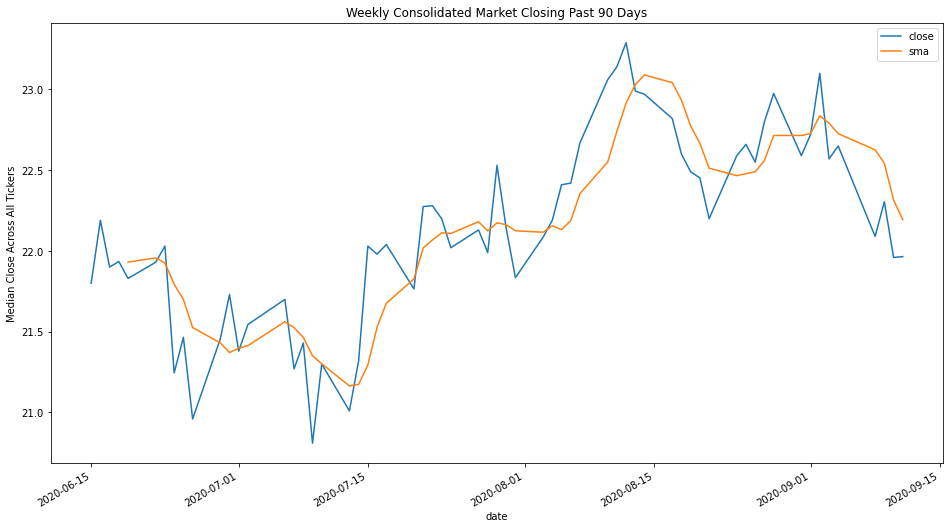

In [4]:
%matplotlib inline

Plot_Data = Total_Market
Plot_Data['date'] = Plot_Data.index.get_level_values('date')
Plot_Data = Plot_Data.reset_index(drop = True)

fig,ax = plt.subplots()
Plot_Data.plot('date','close',ax = ax)
Plot_Data.plot('date','sma',ax = ax)

ax.set(title = "Weekly Consolidated Market Closing Past 90 Days",
      ylabel = "Median Close Across All Tickers")
fig.set_size_inches(16,9)

In [10]:
Sector_Data = defaultdict(pd.DataFrame)
for i in  list(Combined_Data['sector'].unique()):
    TMP = Stock_Consolidator(Combined_Data[Combined_Data['sector'] == i])
    mask = [i in TMP.index.values for i in Total_Market.index.values]
    TM_TMP = Total_Market.iloc[mask,:]
    
    TMP['Market_Return'] = TM_TMP['close_diff']

    ## Rolling OLS Regression
    rols = RollingOLS(TMP['close_diff'],sm.add_constant(TMP['Market_Return']),window = OLS_Window).fit()

    ## Pulling Relevent Information
    alpha_pvalue = list(pd.Series(np.around(rols.pvalues[:,0],2)))
    beta_pvalue = list(pd.Series(np.around(rols.pvalues[:,1],2)))
    alpha = list(rols.params['const'])
    beta = list(rols.params['Market_Return'])
    date = list(TM_TMP.index.values)

    Sector_Data[i] = pd.DataFrame(data = {'date':date,
                                          'alpha_pvalue':alpha_pvalue,
                                          'alpha':alpha,
                                          'beta_pvalue':beta_pvalue,
                                          'beta':beta}).tail(5)
for s in Sector_Data:
    Sector_Data[s].insert(0, 'sector', [s]*len(Sector_Data[s]))

In [16]:
Combined_Sector = pd.concat(Sector_Data.values())  
Combined_Sector.groupby('sector').mean().sort_values(by = ['alpha','alpha_pvalue'],ascending = [0,1])

,alpha_pvalue,alpha,beta_pvalue,beta
sector,,,,
Services,0.200,0.014934,0.010,1.933504
Consumer Cyclical,0.510,0.003587,0.008,0.765083
Utilities,0.552,0.002706,0.018,1.101327
Industrials,0.620,0.002262,0.022,1.262931
Healthcare,0.624,0.002158,0.272,0.960702
Real Estate,0.696,0.002091,0.074,0.593487
Basic Materials,0.634,-0.000493,0.080,0.691394
Conglomerates,0.560,-0.001077,0.250,0.627360
Financial Services,0.410,-0.001459,0.002,0.646425
